# Finetuning

In [1]:
import polars as pl
import logging

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Cargar los datos
df = pl.read_csv('data/diabetic_data.csv')

# Identificar columnas numéricas y categóricas
numeric_cols = df.select(pl.col(pl.Float64)).columns
categorical_cols = df.select(pl.col(pl.Utf8)).columns

# Informar sobre valores faltantes antes de la imputación
missing_values_before = df.select([(pl.col(c).is_null().sum().alias(c)) for c in df.columns])
logger.info(f"Valores faltantes antes de la imputación:\n{missing_values_before}")

# Imputar valores faltantes en columnas numéricas con la mediana
for col in numeric_cols:
    median_value = df.select(pl.col(col).median()).item()
    df = df.with_columns(
        pl.when(pl.col(col).is_null()).then(median_value).otherwise(pl.col(col)).alias(col)
    )

# Imputar valores faltantes en columnas categóricas con la moda
for col in categorical_cols:
    try:
        mode_value = df.select(pl.col(col).mode()).item()
        df = df.with_columns(
            pl.when(pl.col(col).is_null()).then(mode_value).otherwise(pl.col(col)).alias(col)
        )
    except Exception as e:
        logger.error(f"Error imputing column {col}: {e}")

# Verificar si quedan valores faltantes
missing_values_after = df.select([(pl.col(c).is_null().sum().alias(c)) for c in df.columns])
logger.info(f"Valores faltantes después de la imputación:\n{missing_values_after}")

# Mostrar solo las columnas que aún tienen valores faltantes, si las hay
missing_after = {col: count for col, count in zip(missing_values_after.columns, missing_values_after.row(0)) if count > 0}
if missing_after:
    logger.info(f"Columnas con valores faltantes después de la imputación: {missing_after}")
else:
    logger.info("No hay valores faltantes después de la imputación.")


2024-06-27 11:06:40,910 - INFO - Valores faltantes antes de la imputación:
shape: (1, 50)
┌──────────────┬─────────────┬──────┬────────┬───┬────────────────────────┬────────┬─────────────┬────────────┐
│ encounter_id ┆ patient_nbr ┆ race ┆ gender ┆ … ┆ metformin-pioglitazone ┆ change ┆ diabetesMed ┆ readmitted │
│ ---          ┆ ---         ┆ ---  ┆ ---    ┆   ┆ ---                    ┆ ---    ┆ ---         ┆ ---        │
│ u32          ┆ u32         ┆ u32  ┆ u32    ┆   ┆ u32                    ┆ u32    ┆ u32         ┆ u32        │
╞══════════════╪═════════════╪══════╪════════╪═══╪════════════════════════╪════════╪═════════════╪════════════╡
│ 0            ┆ 0           ┆ 0    ┆ 0      ┆ … ┆ 0                      ┆ 0      ┆ 0           ┆ 0          │
└──────────────┴─────────────┴──────┴────────┴───┴────────────────────────┴────────┴─────────────┴────────────┘
2024-06-27 11:06:40,914 - ERROR - Error imputing column race: Caucasian
2024-06-27 11:06:40,918 - ERROR - Error imputing colum

In [2]:
import polars as pl
import logging
import numpy as np

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Función para eliminar outliers utilizando el rango intercuartílico (IQR)
def remove_outliers(df, numeric_cols, factor=2.0):
    logger.info(f"Tamaño del DataFrame antes de eliminar outliers: {df.shape}")
    
    outlier_counts = {}
    
    for col in numeric_cols:
        Q1 = df.select(pl.col(col).quantile(0.25)).to_numpy()[0][0]
        Q3 = df.select(pl.col(col).quantile(0.75)).to_numpy()[0][0]
        IQR = Q3 - Q1

        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        outliers = df.filter((pl.col(col) < lower_bound) | (pl.col(col) > upper_bound))
        outlier_count = outliers.shape[0]
        outlier_counts[col] = outlier_count

        df = df.filter((pl.col(col) >= lower_bound) & (pl.col(col) <= upper_bound))

    logger.info(f"Tamaño del DataFrame después de eliminar outliers: {df.shape}")
    logger.info(f"Outliers encontrados por columna: {outlier_counts}")
    
    return df

# Función para transformar las columnas antes de la eliminación de outliers
def transform_columns(df):
    logger.info("Transformando columnas 'number_outpatient' y 'number_emergency'")
    df = df.with_columns([
        (pl.col('number_outpatient') + 1).log().alias('number_outpatient_log'),
        (pl.col('number_emergency') + 1).log().alias('number_emergency_log')
    ])
    return df

# Transformar las columnas
df = transform_columns(df)

# Eliminar outliers en las columnas numéricas
numeric_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                'number_inpatient', 'number_diagnoses'] # Se excluyen number_outpatient_log y number_emergency_log
df_clean = remove_outliers(df, numeric_cols, factor=2.0)


2024-06-27 11:06:41,117 - INFO - Transformando columnas 'number_outpatient' y 'number_emergency'
2024-06-27 11:06:41,119 - INFO - Tamaño del DataFrame antes de eliminar outliers: (101766, 52)
2024-06-27 11:06:41,178 - INFO - Tamaño del DataFrame después de eliminar outliers: (96733, 52)
2024-06-27 11:06:41,178 - INFO - Outliers encontrados por columna: {'time_in_hospital': 0, 'num_lab_procedures': 14, 'num_procedures': 0, 'num_medications': 1360, 'number_inpatient': 3620, 'number_diagnoses': 39}


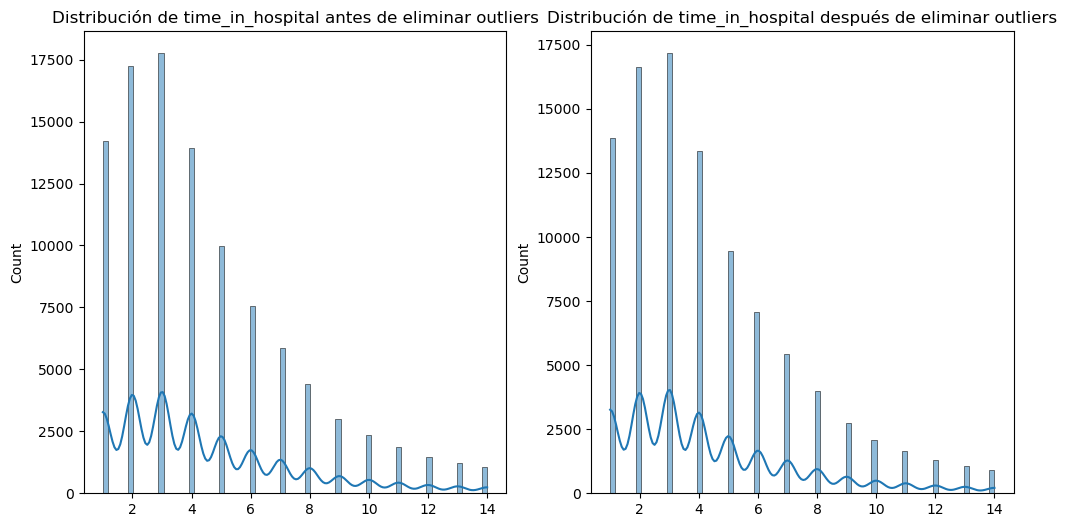

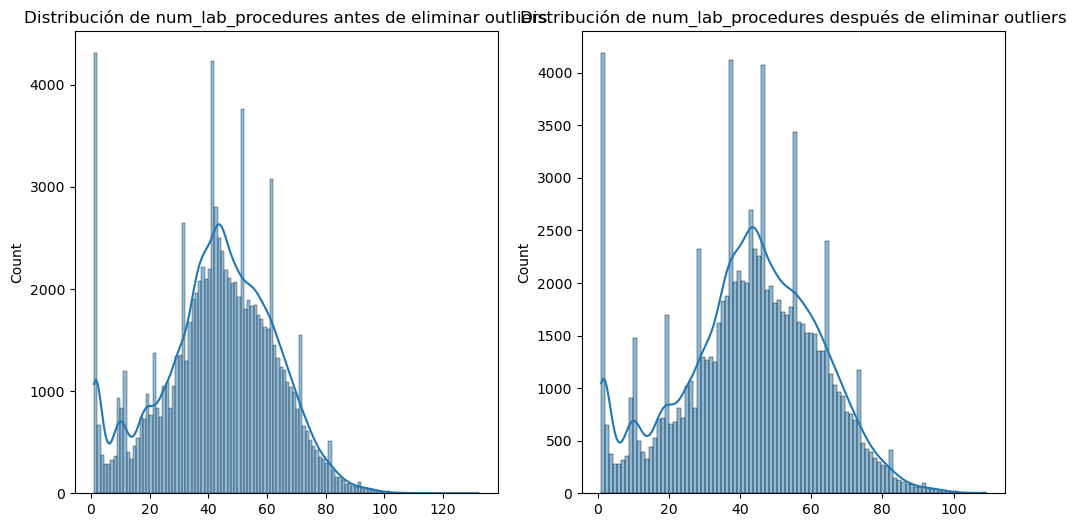

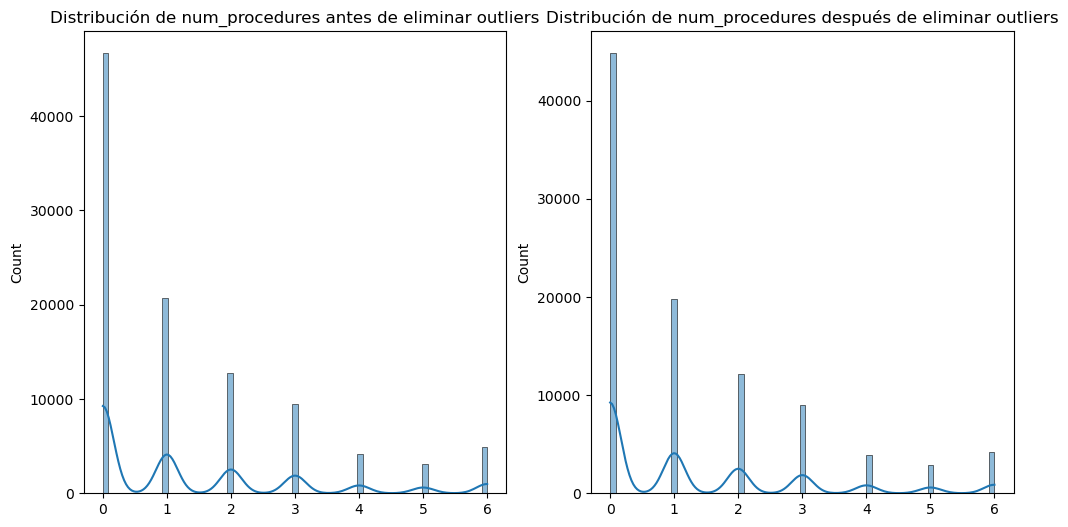

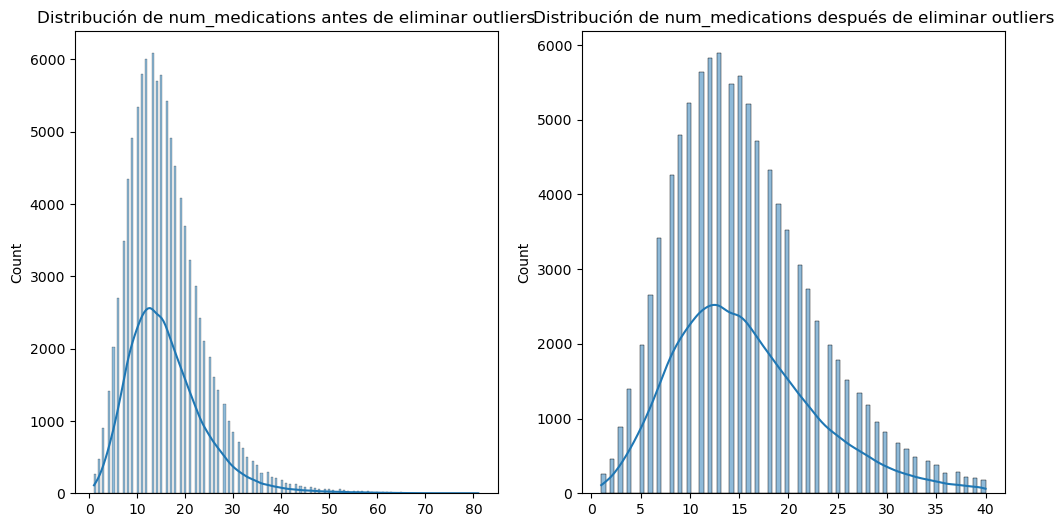

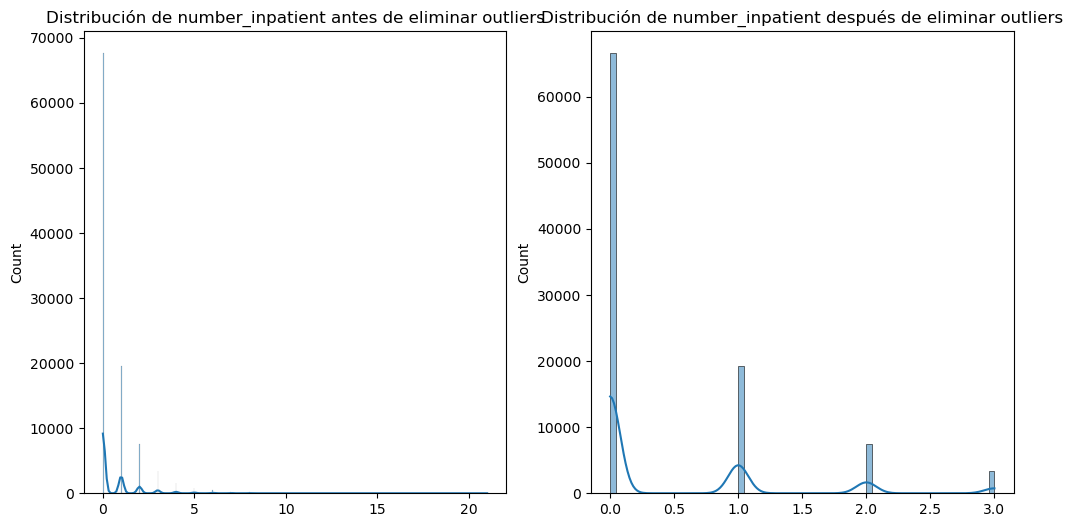

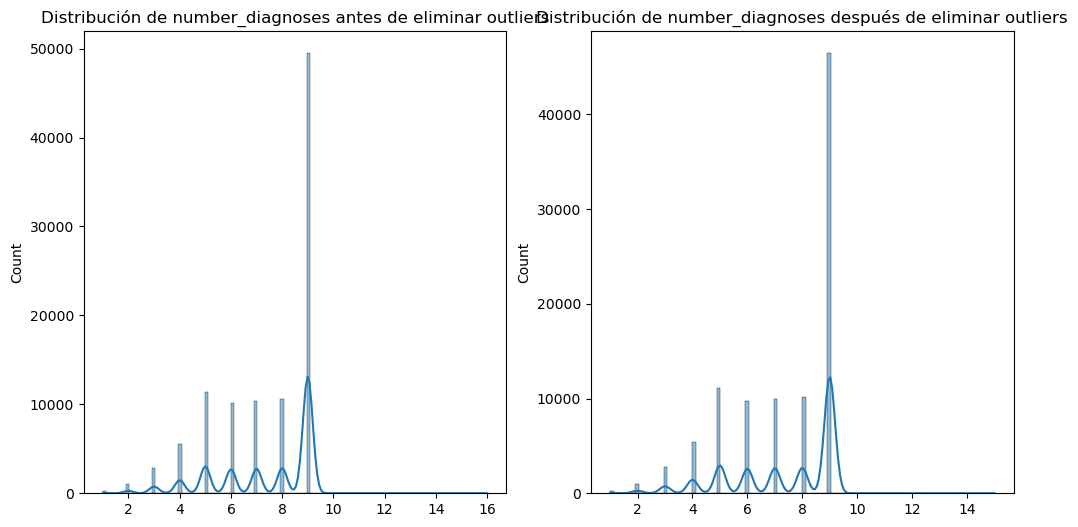

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Función para visualizar la distribución de los datos
def visualize_distributions(df_before, df_after, numeric_cols):
    for col in numeric_cols:
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        sns.histplot(df_before[col], kde=True, ax=axes[0])
        axes[0].set_title(f'Distribución de {col} antes de eliminar outliers')
        
        sns.histplot(df_after[col], kde=True, ax=axes[1])
        axes[1].set_title(f'Distribución de {col} después de eliminar outliers')
        
        plt.show()

# Visualizar la distribución de los datos
visualize_distributions(df, df_clean, numeric_cols)


In [7]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import logging
import pandas as pd

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Seleccionar características y objetivo
logger.info("Seleccionando características y objetivo")
X = df_clean.drop('readmitted')
y = df_clean['readmitted']

# Identificar columnas categóricas y convertirlas a numéricas usando one-hot encoding
logger.info("Convirtiendo columnas categóricas a numéricas usando one-hot encoding")
X = pd.get_dummies(X.to_pandas())

# Dividir los datos en conjuntos de entrenamiento y prueba
logger.info("Dividiendo los datos en conjuntos de entrenamiento y prueba")
X_train, X_test, y_train, y_test = train_test_split(X, y.to_pandas(), test_size=0.2, random_state=42)

# Informar sobre la distribución de las clases antes de SMOTE
logger.info(f"Distribución de las clases antes de SMOTE:\n{y_train.value_counts()}")

# Aplicar SMOTE al conjunto de entrenamiento para clasificación multiclase
logger.info("Aplicando SMOTE al conjunto de entrenamiento")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Informar sobre la distribución de las clases después de SMOTE
logger.info(f"Distribución de las clases después de SMOTE:\n{y_train_smote.value_counts()}")


2024-06-27 11:16:34,430 - INFO - Seleccionando características y objetivo
2024-06-27 11:16:34,433 - INFO - Convirtiendo columnas categóricas a numéricas usando one-hot encoding
2024-06-27 11:16:34,965 - INFO - Dividiendo los datos en conjuntos de entrenamiento y prueba
2024-06-27 11:16:35,374 - INFO - Distribución de las clases antes de SMOTE:
readmitted
NO     42633
>30    26638
<30     8115
Name: count, dtype: int64
2024-06-27 11:16:35,375 - INFO - Aplicando SMOTE al conjunto de entrenamiento
2024-06-27 11:27:41,053 - INFO - Distribución de las clases después de SMOTE:
readmitted
NO     42633
>30    42633
<30    42633
Name: count, dtype: int64


In [ ]:
#import torch
#import torch.nn.functional as F
#import logging
#import random
#from sklearn.model_selection import train_test_split

## Configuración de logging
#logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
#logger = logging.getLogger()

# Función para aplicar SMOTE utilizando PyTorch
#def smote_torch(X, y, minority_class, k=5):
#    # Separar las clases minoritarias y mayoritarias
#    minority_indices = (y == minority_class).nonzero(as_tuple=True)[0]
#    majority_indices = (y != minority_class).nonzero(as_tuple=True)[0]

#    # Obtener ejemplos de la clase minoritaria
#    X_minority = X[minority_indices]
#    y_minority = y[minority_indices]

#    # Generar nuevos ejemplos sintéticos
#    new_examples = []
#    new_labels = []
    
#    for i in range(len(X_minority)):
#        # Encontrar los k vecinos más cercanos
#        distances = F.pairwise_distance(X_minority[i].unsqueeze(0), X_minority)
 #       _, indices = torch.topk(distances, k=k+1, largest=False)
 #       indices = indices[1:]  # Ignorar la distancia a sí mismo

 #       # Crear un nuevo ejemplo sintético
 #       neighbor_index = random.choice(indices)
 #       diff = X_minority[neighbor_index] - X_minority[i]
 #       new_example = X_minority[i] + torch.rand(1).to(X.device) * diff
 #       new_examples.append(new_example)
 #       new_labels.append(torch.tensor([minority_class], device=X.device))

 #   new_examples = torch.stack(new_examples)
 #   new_labels = torch.cat(new_labels)

 #   # Concatenar los nuevos ejemplos sintéticos con los datos originales
 #   X_resampled = torch.cat([X, new_examples])
 #   y_resampled = torch.cat([y, new_labels])

#    return X_resampled, y_resampled

## Seleccionar características y objetivo
#logger.info("Seleccionando características y objetivo")
#X = df_clean.drop('readmitted').to_numpy()
#y = df_clean['readmitted'].to_numpy()

## Convertir a tensores de PyTorch y mover a GPU si está disponible
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
#y_tensor = torch.tensor(y, dtype=torch.long).to(device)

## Dividir los datos en conjuntos de entrenamiento y prueba
#logger.info("Dividiendo los datos en conjuntos de entrenamiento y prueba")
#X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

## Informar sobre la distribución de las clases antes de SMOTE
#logger.info(f"Distribución de las clases antes de SMOTE:\n{torch.bincount(y_train)}")

## Aplicar SMOTE utilizando PyTorch
#logger.info("Aplicando SMOTE al conjunto de entrenamiento")
#X_train_smote, y_train_smote = smote_torch(X_train, y_train, minority_class=1)  # Cambia '1' a la clase minoritaria que corresponda

## Informar sobre la distribución de las clases después de SMOTE
#logger.info(f"Distribución de las clases después de SMOTE:\n{torch.bincount(y_train_smote)}")


In [10]:
import polars as pl
import logging

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Función para realizar ingeniería de características
def feature_engineering(df):
    logger.info("Iniciando la ingeniería de características")
    
    # Creación de nuevas características basadas en características existentes
    df = df.with_columns([
        (pl.col("time_in_hospital") / pl.col("num_medications")).alias("medications_per_day"),
        (pl.col("num_lab_procedures") / pl.col("time_in_hospital")).alias("lab_procedures_per_day"),
        (pl.col("number_inpatient") / (pl.col("number_outpatient") + 1)).alias("inpatient_outpatient_ratio")
    ])
    
    logger.info("Nuevas características creadas")
    
    # Transformación de características existentes
    df = df.with_columns([
        pl.col("age").str.extract(r"(\d+)", 1).cast(pl.Int32).alias("age_lower"),
        (pl.col("age").str.extract(r"(\d+)", 1).cast(pl.Int32) + 5).alias("age_mean")
    ])
    
    logger.info("Características transformadas")
    
    # Codificación de variables categóricas
    categorical_cols = [
        'race', 'gender', 'payer_code', 'medical_specialty', 
        'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 
        'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 
        'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 
        'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 
        'tolazamide', 'examide', 'citoglipton', 'insulin', 
        'glyburide-metformin', 'glipizide-metformin', 
        'glimepiride-pioglitazone', 'metformin-rosiglitazone', 
        'metformin-pioglitazone', 'change', 'diabetesMed'
    ]
    
    for col in categorical_cols:
        unique_vals = df[col].unique().to_list()
        mapping = {val: idx for idx, val in enumerate(unique_vals)}
        df = df.with_columns(
            pl.col(col).map_dict(mapping).cast(pl.Int64).alias(col)
        )
    
    logger.info("Variables categóricas codificadas")
    
    return df

# Aplicar ingeniería de características al DataFrame
df_engineered = feature_engineering(df_clean)

# Verificar las primeras filas del DataFrame después de la ingeniería de características
logger.info(f"Primeras filas del DataFrame después de la ingeniería de características:\n{df_engineered.head()}")


2024-06-27 11:36:19,324 - INFO - Iniciando la ingeniería de características
2024-06-27 11:36:19,326 - INFO - Nuevas características creadas
2024-06-27 11:36:19,346 - INFO - Características transformadas
C:\Users\dchav\AppData\Local\Temp\ipykernel_9552\395962929.py:46: DeprecationWarning: `map_dict` is deprecated. It has been renamed to `replace`. The default behavior has changed to keep any values not present in the mapping unchanged. Pass `default=None` to keep existing behavior.
  pl.col(col).map_dict(mapping).cast(pl.Int64).alias(col)
2024-06-27 11:36:19,444 - INFO - Variables categóricas codificadas
2024-06-27 11:36:19,449 - INFO - Primeras filas del DataFrame después de la ingeniería de características:
shape: (5, 57)
┌──────────────┬─────────────┬──────┬────────┬───┬────────────────────────┬────────────────────────────┬───────────┬──────────┐
│ encounter_id ┆ patient_nbr ┆ race ┆ gender ┆ … ┆ lab_procedures_per_day ┆ inpatient_outpatient_ratio ┆ age_lower ┆ age_mean │
│ ---      

In [11]:
import polars as pl
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import logging

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Función para normalizar y estandarizar las características
def normalize_and_standardize(df, numeric_cols):
    logger.info("Iniciando la normalización y estandarización")

    # Convertir DataFrame de polars a pandas para usar con sklearn
    df_pd = df.to_pandas()
    
    # Inicializar escaladores
    scaler_standard = StandardScaler()
    scaler_minmax = MinMaxScaler()

    # Aplicar escaladores
    df_pd[numeric_cols] = scaler_standard.fit_transform(df_pd[numeric_cols])
    df_pd[numeric_cols] = scaler_minmax.fit_transform(df_pd[numeric_cols])

    logger.info("Normalización y estandarización completadas")

    # Convertir DataFrame de pandas a polars
    df_normalized = pl.from_pandas(df_pd)
    
    return df_normalized

# Columnas numéricas a normalizar y estandarizar
numeric_cols = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses',
    'medications_per_day', 'lab_procedures_per_day', 'inpatient_outpatient_ratio', 'age_mean'
]

# Aplicar normalización y estandarización al DataFrame
df_normalized = normalize_and_standardize(df_engineered, numeric_cols)

# Verificar las primeras filas del DataFrame después de la normalización y estandarización
logger.info(f"Primeras filas del DataFrame después de la normalización y estandarización:\n{df_normalized.head()}")


2024-06-27 11:38:20,731 - INFO - Iniciando la normalización y estandarización
2024-06-27 11:38:20,843 - INFO - Normalización y estandarización completadas
2024-06-27 11:38:20,911 - INFO - Primeras filas del DataFrame después de la normalización y estandarización:
shape: (5, 57)
┌──────────────┬─────────────┬──────┬────────┬───┬────────────────────────┬────────────────────────────┬───────────┬──────────┐
│ encounter_id ┆ patient_nbr ┆ race ┆ gender ┆ … ┆ lab_procedures_per_day ┆ inpatient_outpatient_ratio ┆ age_lower ┆ age_mean │
│ ---          ┆ ---         ┆ ---  ┆ ---    ┆   ┆ ---                    ┆ ---                        ┆ ---       ┆ ---      │
│ i64          ┆ i64         ┆ i64  ┆ i64    ┆   ┆ f64                    ┆ f64                        ┆ i32       ┆ f64      │
╞══════════════╪═════════════╪══════╪════════╪═══╪════════════════════════╪════════════════════════════╪═══════════╪══════════╡
│ 2278392      ┆ 8222157     ┆ 4    ┆ 2      ┆ … ┆ 0.422255               ┆ 0.0  

In [14]:
import polars as pl
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import logging

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

# Codificar variables categóricas
def encode_categorical(df):
    logger.info("Codificando variables categóricas")
    for col in df.columns:
        if df[col].dtype == pl.Utf8:
            le = LabelEncoder()
            df = df.with_columns(pl.Series(name=col, values=le.fit_transform(df[col].to_numpy())))
    return df

# Aplicar la codificación de variables categóricas
df_encoded = encode_categorical(df_normalized)

# Seleccionar características y objetivo
X = df_encoded.drop('readmitted')
y = df_encoded['readmitted']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir DataFrame de polars a pandas para usar con sklearn
X_train_pd = X_train.to_pandas().astype(float)
y_train_pd = y_train.to_pandas().astype(float)
X_test_pd = X_test.to_pandas().astype(float)
y_test_pd = y_test.to_pandas().astype(float)

# Asegurarse de que las etiquetas sean enteros
y_train_pd = y_train_pd.astype(int)
y_test_pd = y_test_pd.astype(int)

# Entrenar modelo de Gradient Boosting para obtener la importancia de características
logger.info("Entrenando modelo de Gradient Boosting para obtener la importancia de características")
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_pd, y_train_pd)

# Obtener importancia de características
feature_importances = pd.Series(gb_model.feature_importances_, index=X_train_pd.columns)
selected_features = feature_importances[feature_importances > 0.01].index

logger.info(f"Características seleccionadas por importancia: {selected_features.tolist()}")

# Reducir X_train y X_test a las características seleccionadas
X_train_selected = X_train_pd[selected_features]
X_test_selected = X_test_pd[selected_features]

# Aplicar RFE para seleccionar características
logger.info("Aplicando Recursive Feature Elimination (RFE) para seleccionar características")
rfe = RFE(estimator=gb_model, n_features_to_select=10)
rfe.fit(X_train_selected, y_train_pd)

rfe_selected_features = X_train_selected.columns[rfe.support_]
logger.info(f"Características seleccionadas por RFE: {rfe_selected_features.tolist()}")

# Reducir X_train y X_test a las características seleccionadas por RFE
X_train_rfe = X_train_selected[rfe_selected_features]
X_test_rfe = X_test_selected[rfe_selected_features]

# Verificar las primeras filas del DataFrame después de la selección de características
logger.info(f"Primeras filas del DataFrame de entrenamiento después de la selección de características:\n{X_train_rfe.head()}")
logger.info(f"Primeras filas del DataFrame de prueba después de la selección de características:\n{X_test_rfe.head()}")


2024-06-27 11:43:54,162 - INFO - Codificando variables categóricas
2024-06-27 11:43:54,376 - INFO - Entrenando modelo de Gradient Boosting para obtener la importancia de características
2024-06-27 11:45:03,166 - INFO - Características seleccionadas por importancia: ['encounter_id', 'patient_nbr', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'diabetesMed', 'number_outpatient_log', 'number_emergency_log', 'inpatient_outpatient_ratio']
2024-06-27 11:45:03,172 - INFO - Aplicando Recursive Feature Elimination (RFE) para seleccionar características
2024-06-27 11:50:07,419 - INFO - Características seleccionadas por RFE: ['encounter_id', 'patient_nbr', 'discharge_disposition_id', 'admission_source_id', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'number_diagnoses', 'inpatient_outpatient_ratio']
2024-06-27 11:50:0

In [15]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score
import optuna
import logging

# Configuración de logging
logger = logging.getLogger()

# Definir la función de puntuación personalizada
scorer = make_scorer(f1_score, average='weighted')

# Grid Search
def grid_search(X, y):
    logger.info("Iniciando Grid Search")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
    grid_search = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), param_grid=param_grid, scoring=scorer, cv=3)
    grid_search.fit(X, y)
    logger.info(f"Mejores parámetros de Grid Search: {grid_search.best_params_}")
    return grid_search.best_estimator_

# Random Search
def random_search(X, y):
    logger.info("Iniciando Random Search")
    param_dist = {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [3, 4, 5, 6, 7, 8]
    }
    random_search = RandomizedSearchCV(estimator=GradientBoostingClassifier(random_state=42), param_distributions=param_dist, scoring=scorer, n_iter=50, cv=3, random_state=42)
    random_search.fit(X, y)
    logger.info(f"Mejores parámetros de Random Search: {random_search.best_params_}")
    return random_search.best_estimator_

# Bayesian Optimization using Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)
    score = cross_val_score(clf, X_train_rfe, y_train_pd, scoring=scorer, cv=3).mean()
    return score

def bayesian_optimization(X, y):
    logger.info("Iniciando Bayesian Optimization")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    logger.info(f"Mejores parámetros de Bayesian Optimization: {study.best_params}")
    
    best_params = study.best_params
    best_model = GradientBoostingClassifier(**best_params, random_state=42)
    best_model.fit(X, y)
    return best_model

# Aplicar las técnicas de ajuste de hiperparámetros
logger.info("Aplicando Grid Search")
best_model_grid = grid_search(X_train_rfe, y_train_pd)

logger.info("Aplicando Random Search")
best_model_random = random_search(X_train_rfe, y_train_pd)

logger.info("Aplicando Bayesian Optimization")
best_model_bayes = bayesian_optimization(X_train_rfe, y_train_pd)

# Evaluar el mejor modelo de cada método en el conjunto de prueba
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

logger.info("Evaluando el mejor modelo de Grid Search")
accuracy_grid, precision_grid, recall_grid, f1_grid = evaluate_model(best_model_grid, X_test_rfe, y_test_pd)
logger.info(f"Grid Search - Accuracy: {accuracy_grid}, Precision: {precision_grid}, Recall: {recall_grid}, F1 Score: {f1_grid}")

logger.info("Evaluando el mejor modelo de Random Search")
accuracy_random, precision_random, recall_random, f1_random = evaluate_model(best_model_random, X_test_rfe, y_test_pd)
logger.info(f"Random Search - Accuracy: {accuracy_random}, Precision: {precision_random}, Recall: {recall_random}, F1 Score: {f1_random}")

logger.info("Evaluando el mejor modelo de Bayesian Optimization")
accuracy_bayes, precision_bayes, recall_bayes, f1_bayes = evaluate_model(best_model_bayes, X_test_rfe, y_test_pd)
logger.info(f"Bayesian Optimization - Accuracy: {accuracy_bayes}, Precision: {precision_bayes}, Recall: {recall_bayes}, F1 Score: {f1_bayes}")


ModuleNotFoundError: No module named 'optuna'

In [17]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
import xgboost as xgb
import logging

# Configuración de logging
logger = logging.getLogger()

# Definir la función de puntuación personalizada
scorer = make_scorer(f1_score, average='weighted')

# Grid Search
def grid_search(X, y):
    logger.info("Iniciando Grid Search")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'tree_method': ['hist'],  # Utilizar hist y especificar dispositivo
        'device': ['cuda']  # Utilizar GPU
    }
    grid_search = GridSearchCV(estimator=xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'), param_grid=param_grid, scoring=scorer, cv=3)
    grid_search.fit(X, y)
    logger.info(f"Mejores parámetros de Grid Search: {grid_search.best_params_}")
    return grid_search.best_estimator_

# Random Search
def random_search(X, y):
    logger.info("Iniciando Random Search")
    param_dist = {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [3, 4, 5, 6, 7, 8],
        'tree_method': ['hist'],  # Utilizar hist y especificar dispositivo
        'device': ['cuda']  # Utilizar GPU
    }
    random_search = RandomizedSearchCV(estimator=xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'), param_distributions=param_dist, scoring=scorer, n_iter=50, cv=3, random_state=42)
    random_search.fit(X, y)
    logger.info(f"Mejores parámetros de Random Search: {random_search.best_params_}")
    return random_search.best_estimator_

# Aplicar las técnicas de ajuste de hiperparámetros
logger.info("Aplicando Grid Search")
best_model_grid = grid_search(X_train_rfe, y_train_pd)

logger.info("Aplicando Random Search")
best_model_random = random_search(X_train_rfe, y_train_pd)

# Evaluar el mejor modelo de cada método en el conjunto de prueba
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

logger.info("Evaluando el mejor modelo de Grid Search")
accuracy_grid, precision_grid, recall_grid, f1_grid = evaluate_model(best_model_grid, X_test_rfe, y_test_pd)
logger.info(f"Grid Search - Accuracy: {accuracy_grid}, Precision: {precision_grid}, Recall: {recall_grid}, F1 Score: {f1_grid}")

logger.info("Evaluando el mejor modelo de Random Search")
accuracy_random, precision_random, recall_random, f1_random = evaluate_model(best_model_random, X_test_rfe, y_test_pd)
logger.info(f"Random Search - Accuracy: {accuracy_random}, Precision: {precision_random}, Recall: {recall_random}, F1 Score: {f1_random}")


2024-06-27 12:15:35,263 - INFO - Aplicando Grid Search
2024-06-27 12:15:35,264 - INFO - Iniciando Grid Search
2024-06-27 12:17:34,035 - INFO - Mejores parámetros de Grid Search: {'device': 'cuda', 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'tree_method': 'hist'}
2024-06-27 12:17:34,036 - INFO - Aplicando Random Search
2024-06-27 12:17:34,036 - INFO - Iniciando Random Search
2024-06-27 12:22:43,191 - INFO - Mejores parámetros de Random Search: {'tree_method': 'hist', 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.2, 'device': 'cuda'}
2024-06-27 12:22:43,193 - INFO - Evaluando el mejor modelo de Grid Search
2024-06-27 12:22:43,224 - INFO - Grid Search - Accuracy: 0.615599317723678, Precision: 0.5947252588119772, Recall: 0.615599317723678, F1 Score: 0.576971395358864
2024-06-27 12:22:43,225 - INFO - Evaluando el mejor modelo de Random Search
2024-06-27 12:22:43,264 - INFO - Random Search - Accuracy: 0.6142554401199153, Precision: 0.5908096945425191, Recall: 0.6142

In [19]:
import optuna
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# Definir la función objetiva para Optuna
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'tree_method': 'hist',  # Utilizar hist y especificar dispositivo
        'device': 'cuda',  # Utilizar GPU
        'num_class': 3,  # Número de clases en la clasificación multiclase
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 1e-8, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    
    # Realizar un split en los datos
    X_train_bayesian, X_val, y_train_bayesian, y_val = train_test_split(X_train_rfe, y_train_pd, test_size=0.2, random_state=42)
    
    dtrain = xgb.DMatrix(X_train_bayesian, label=y_train_bayesian)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    # Entrenar el modelo
    model = xgb.train(param, dtrain, evals=[(dval, 'validation')], verbose_eval=False)
    
    # Hacer predicciones
    preds = model.predict(dval)
    pred_labels = np.argmax(preds, axis=1)
    
    # Calcular la puntuación f1
    f1 = f1_score(y_val, pred_labels, average='weighted')
    
    return f1

# Crear el estudio de Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Obtener los mejores parámetros
best_params = study.best_params
logger.info(f"Mejores parámetros de Bayesian Optimization: {best_params}")

# Entrenar el modelo final con los mejores parámetros en el conjunto completo de entrenamiento
final_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    eval_metric='mlogloss',
    tree_method='hist',
    device='cuda',
    use_label_encoder=False
)
final_model.fit(X_train_rfe, y_train_pd)

# Evaluar el modelo final en el conjunto de prueba
logger.info("Evaluando el mejor modelo de Bayesian Optimization")
accuracy_bayesian, precision_bayesian, recall_bayesian, f1_bayesian = evaluate_model(final_model, X_test_rfe, y_test_pd)
logger.info(f"Bayesian Optimization - Accuracy: {accuracy_bayesian}, Precision: {precision_bayesian}, Recall: {recall_bayesian}, F1 Score: {f1_bayesian}")


[I 2024-06-27 12:28:16,527] A new study created in memory with name: no-name-f7004fd0-9051-494b-ba41-e764d6481711
[I 2024-06-27 12:28:16,873] Trial 0 finished with value: 0.527317283735224 and parameters: {'lambda': 0.00017844231353503573, 'alpha': 0.0009433826070344754, 'colsample_bytree': 0.9764140372176702, 'subsample': 0.4543259121009694, 'learning_rate': 0.25769066248426375, 'n_estimators': 266, 'max_depth': 3, 'min_child_weight': 2}. Best is trial 0 with value: 0.527317283735224.
[I 2024-06-27 12:28:17,181] Trial 1 finished with value: 0.5017956219525993 and parameters: {'lambda': 3.5909628887527656e-08, 'alpha': 0.046552529396607575, 'colsample_bytree': 0.5700673615963676, 'subsample': 0.5077928280254894, 'learning_rate': 4.5871312368921685e-05, 'n_estimators': 251, 'max_depth': 5, 'min_child_weight': 8}. Best is trial 0 with value: 0.527317283735224.
[I 2024-06-27 12:28:17,486] Trial 2 finished with value: 0.48345192746391913 and parameters: {'lambda': 0.08183081807514175, 'alp

In [20]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# Función para realizar validación cruzada
def cross_validation(model, X, y, stratified=True, n_splits=5):
    logger.info(f"Iniciando validación cruzada con {'StratifiedKFold' if stratified else 'KFold'}")
    
    if stratified:
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    else:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    f1_scorer = make_scorer(f1_score, average='weighted')
    scores = cross_val_score(model, X, y, cv=kf, scoring=f1_scorer)
    
    logger.info(f"Puntuaciones de F1 en cada pliegue: {scores}")
    logger.info(f"Media de la puntuación F1: {np.mean(scores)}")
    logger.info(f"Desviación estándar de la puntuación F1: {np.std(scores)}")
    
    return scores

# Instancia del modelo final con los mejores parámetros
final_model = xgb.XGBClassifier(
    **best_params,
    objective='multi:softprob',
    eval_metric='mlogloss',
    tree_method='hist',
    device='cuda',
    use_label_encoder=False
)

# Realizar validación cruzada estratificada
scores = cross_validation(final_model, X_train_rfe, y_train_pd, stratified=True, n_splits=5)


2024-06-27 12:47:08,392 - INFO - Iniciando validación cruzada con StratifiedKFold
2024-06-27 12:47:50,209 - INFO - Puntuaciones de F1 en cada pliegue: [0.5431585  0.54519209 0.54102054 0.54808062 0.54338032]
2024-06-27 12:47:50,210 - INFO - Media de la puntuación F1: 0.5441664131845114
2024-06-27 12:47:50,211 - INFO - Desviación estándar de la puntuación F1: 0.0023623473870342374


2024-06-27 12:52:22,859 - INFO - Evaluando el modelo en el conjunto de prueba
2024-06-27 12:52:31,822 - INFO - Accuracy: 0.5678399751899519
2024-06-27 12:52:31,824 - INFO - Precision: 0.538737093866867
2024-06-27 12:52:31,824 - INFO - Recall: 0.5678399751899519
2024-06-27 12:52:31,824 - INFO - F1 Score: 0.5482451321945538
2024-06-27 12:52:31,825 - INFO - ROC AUC: 0.6398566908221516


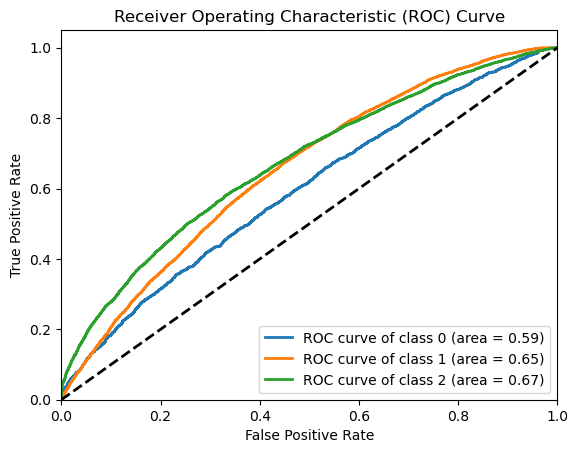

2024-06-27 12:52:32,070 - INFO - Generando curvas de aprendizaje


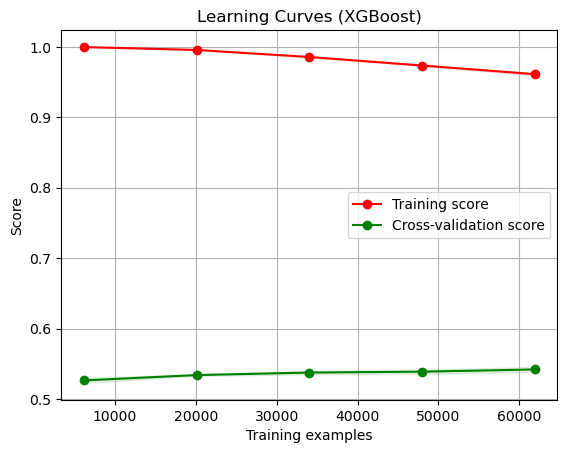

In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
import numpy as np

# Evaluar el modelo en el conjunto de prueba
logger.info("Evaluando el modelo en el conjunto de prueba")
final_model.fit(X_train_rfe, y_train_pd)
y_pred = final_model.predict(X_test_rfe)
y_prob = final_model.predict_proba(X_test_rfe)

# Calcular métricas de evaluación
accuracy = accuracy_score(y_test_pd, y_pred)
precision = precision_score(y_test_pd, y_pred, average='weighted')
recall = recall_score(y_test_pd, y_pred, average='weighted')
f1 = f1_score(y_test_pd, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test_pd, y_prob, multi_class='ovr')

logger.info(f"Accuracy: {accuracy}")
logger.info(f"Precision: {precision}")
logger.info(f"Recall: {recall}")
logger.info(f"F1 Score: {f1}")
logger.info(f"ROC AUC: {roc_auc}")

# Plotear la curva ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_test_pd))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_pd == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Curvas de Aprendizaje
logger.info("Generando curvas de aprendizaje")

def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1_weighted')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

plot_learning_curve(final_model, "Learning Curves (XGBoost)", X_train_rfe, y_train_pd, cv=5)
plt.show()


# Conclusion
     El modelo tiene un desempeño moderado para distinguir entre las clases.
     El modelo tiene un desempeño equilibrado pero aún moderado en términos de precisión y recall.
     La F1-Score, que es el balance entre precisión y recall, también indica que hay margen para mejoras significativas.
     El modelo está sobreajustando.

# Mejoras
    Ajustar los hiperparámetros de regularización como alpha (L1 regularización) y lambda (L2 regularización) puede ayudar a reducir el sobreajuste.
    Incrementar la cantidad de datos de entrenamiento puede ayudar a mejorar el desempeño del modelo.
    Hacer otra ronda de búsqueda de hiperparámetros.
    Usar técnicas de ensamblaje como Stacking, Bagging o Boosting para combinar múltiples modelos y mejorar la robustez y el desempeño general.
    Hacer mas Feature Engineering.
    Reducir la dimensionalidad.
    Submuestreo de clase dominante.
    Ver como mejorar la Validacion Cruzada.